In [2]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from keras.optimizers import Adam
#from tensorflow.keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import itertools, os, random, shutil, glob

In [44]:
os.chdir("C://Users//robin//Documents//GitHub//kitchenware_classification//")
os.getcwd()

'C:\\Users\\robin\\Documents\\GitHub\\kitchenware_classification'

In [45]:
if os.path.isdir('./data') is True:
    os.system("rm -r ./data")    
    print('data folder removed')
else:
    print('No data folder yet')

No data folder yet


In [46]:
sample_submission = pd.read_csv('./sample_submission.csv')
train = pd.read_csv('./train.csv')
submission = pd.read_csv('./test.csv')
images_dir = './images/'

In [47]:
os.listdir('./images/')[:5]

['0000.jpg', '0001.jpg', '0002.jpg', '0003.jpg', '0004.jpg']

In [48]:
sample_submission.head()

,Id,label
0,678,spoon
1,3962,glass
2,9271,spoon
3,5133,plate
4,8842,spoon


In [49]:
train['Id'] = train['Id'].apply(lambda x: str(x).zfill(4))
train_dic = dict(zip(train['Id'], train['label']))
train['Id'] = train['Id'].astype(str)

def add_leading_word(row):
    if row['label'] == 'glass':
        return row['label'] + row['Id']
    elif row['label'] == 'cup':
        return row['label'] + row['Id']
    elif row['label'] == 'spoon':
        return row['label'] + row['Id']
    elif row['label'] == 'plate':
        return row['label'] + row['Id']
    elif row['label'] == 'knife':
        return row['label'] + row['Id']
    elif row['label'] == 'fork':
        return row['label'] + row['Id']   
    else:
        return row['label']

# Apply the custom function to the dataframe using the apply() function
train['label_id'] = train.apply(add_leading_word, axis=1)

train['Id'] = train['Id'].apply(lambda x: x + '.jpg')
train['label_id'] = train['label_id'].apply(lambda x: x + '.jpg')
train.head()

,Id,label,label_id
0,0560.jpg,glass,glass0560.jpg
1,4675.jpg,cup,cup4675.jpg
2,0875.jpg,glass,glass0875.jpg
3,4436.jpg,spoon,spoon4436.jpg
4,8265.jpg,plate,plate8265.jpg


In [50]:
rename_train_dic = dict(zip(train['Id'], train['label_id']))

"""
{'0560.jpg': 'glass0560.jpg',
 '4675.jpg': 'cup4675.jpg',
 '0875.jpg': 'glass0875.jpg',
 '4436.jpg': 'spoon4436.jpg',
 '8265.jpg': 'plate8265.jpg',..}"""

"\n{'0560.jpg': 'glass0560.jpg',\n '4675.jpg': 'cup4675.jpg',\n '0875.jpg': 'glass0875.jpg',\n '4436.jpg': 'spoon4436.jpg',\n '8265.jpg': 'plate8265.jpg',..}"

In [51]:
submission.head()

,Id
0,678
1,3962
2,9271
3,5133
4,8842


In [52]:
submission['Id'] = submission['Id'].apply(lambda x: str(x).zfill(4))
submission['Id'] = submission['Id'].astype(str)
submission['Id'] = submission['Id'].apply(lambda x: x + '.jpg')
submission.head()

,Id
0,0678.jpg
1,3962.jpg
2,9271.jpg
3,5133.jpg
4,8842.jpg


* images_dir holds the images, names as their Id
* the training df holds a column with the Id's and a column with the label 
    - we need:
        - an array with the images
        - an array with the labels

<AxesSubplot:>

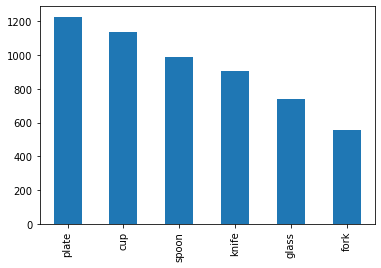

In [53]:
train.label.value_counts().plot(kind='bar')

In [54]:
train.label.unique()

array(['glass', 'cup', 'spoon', 'plate', 'knife', 'fork'], dtype=object)

In [55]:
len(train[train['label']=='fork'])

557

The label with the least amount of images is fork, will create train valid and test folders with this number of images for each:
- train: 400
- test: 100
- valid: 50
- SUM: 550

In [56]:
os.getcwd()

'C:\\Users\\robin\\Documents\\GitHub\\kitchenware_classification'

In [57]:
print(f"Current directory is: {os.getcwd()}")

if os.path.isdir('./data') is False:
    os.makedirs('./data')
    print('Created a data folder')
else:
    print('folder data already exists.')
    
os.chdir('./data')
print(f"Current directory is: {os.getcwd()}")

Current directory is: C:\Users\robin\Documents\GitHub\kitchenware_classification
Created a data folder
Current directory is: C:\Users\robin\Documents\GitHub\kitchenware_classification\data


In [58]:
if os.path.isdir('train/plate') is False:
    os.makedirs('train/plate')
    os.makedirs('train/cup')
    os.makedirs('train/spoon')
    os.makedirs('train/knife')
    os.makedirs('train/glass')
    os.makedirs('train/fork')
    
    os.makedirs('valid/plate')
    os.makedirs('valid/cup')
    os.makedirs('valid/spoon')
    os.makedirs('valid/knife')
    os.makedirs('valid/glass')
    os.makedirs('valid/fork')
    
    os.makedirs('test/plate')
    os.makedirs('test/cup')
    os.makedirs('test/spoon')
    os.makedirs('test/knife')
    os.makedirs('test/glass')
    os.makedirs('test/fork')
    print('created train/valid/test folders for all the labels')
else:
    print('folder train/plate already exists, check if the other ones are also already created.')

created train/valid/test folders for all the labels


In [59]:
dict_directories_to_check = {'train/plate':0,
                             'train/cup':0,
                             'train/spoon':0,
                             'train/knife':0,
                             'train/glass':0,
                             'train/fork':0,              
                             'valid/plate':0,
                             'valid/cup':0,
                             'valid/spoon':0,
                             'valid/knife':0,
                             'valid/glass':0,
                             'valid/fork':0,
                             'test/plate':0,
                             'test/cup':0,
                             'test/spoon':0,
                             'test/knife':0,
                             'test/glass':0,
                             'test/fork':0}
directories_to_check = ['train/plate',
                         'train/cup',
                         'train/spoon',
                         'train/knife',
                         'train/glass',
                         'train/fork',              
                         'valid/plate',
                         'valid/cup',
                         'valid/spoon',
                         'valid/knife',
                         'valid/glass',
                         'valid/fork',
                         'test/plate',
                         'test/cup',
                         'test/spoon',
                         'test/knife',
                         'test/glass',
                         'test/fork']
for dr in directories_to_check:
    if len(os.listdir(dr)) == 0:
        print(f"{dr} is empty")
        dict_directories_to_check[dr]=0
    else:    
        print(f"{dr} is not empty")
        dict_directories_to_check[dr]=1

train/plate is empty
train/cup is empty
train/spoon is empty
train/knife is empty
train/glass is empty
train/fork is empty
valid/plate is empty
valid/cup is empty
valid/spoon is empty
valid/knife is empty
valid/glass is empty
valid/fork is empty
test/plate is empty
test/cup is empty
test/spoon is empty
test/knife is empty
test/glass is empty
test/fork is empty


400
100
50


In [69]:
os.chdir('../')
print(os.getcwd())

C:\Users\robin\Documents\GitHub\kitchenware_classification\images
C:\Users\robin\Documents\GitHub\kitchenware_classification


In [67]:
submission.head()

,Id
0,0678.jpg
1,3962.jpg
2,9271.jpg
3,5133.jpg
4,8842.jpg


In [143]:
submission_images_to_exclude_from_training = submission.Id.to_list()
submission_images_to_exclude_from_training[:5]

['0678.jpg', '3962.jpg', '9271.jpg', '5133.jpg', '8842.jpg']

### Copy all the images from '/images' to '/data'


In [70]:
from distutils.dir_util import copy_tree
from IPython.display import clear_output

from_dir = './images'
to_dir = './data'

copy_tree(from_dir, to_dir)
clear_output()
print('(images -> data transfer ok, output cleared)')

(images -> data transfer ok, output cleared)


### Remove the submission images from '/data'

In [71]:
print(os.getcwd())
os.chdir('./data')
print(os.getcwd())

C:\Users\robin\Documents\GitHub\kitchenware_classification
C:\Users\robin\Documents\GitHub\kitchenware_classification\data


In [72]:
# List of files to be deleted
file_list = submission_images_to_exclude_from_training

# Iterate through the list and delete each file
for file in file_list:
    # Use the os.remove() method to delete the file
    os.remove(file)

### Rename the jpg files with their corresponding label in the front

In [74]:
#rename_train_dic

"""
{'0560.jpg': 'glass0560.jpg',
 '4675.jpg': 'cup4675.jpg',
 '0875.jpg': 'glass0875.jpg',
 '4436.jpg': 'spoon4436.jpg',
 '8265.jpg': 'plate8265.jpg',
 '2422.jpg': 'cup2422.jpg',"""

"\n{'0560.jpg': 'glass0560.jpg',\n '4675.jpg': 'cup4675.jpg',\n '0875.jpg': 'glass0875.jpg',\n '4436.jpg': 'spoon4436.jpg',\n '8265.jpg': 'plate8265.jpg',\n '2422.jpg': 'cup2422.jpg',"

In [75]:
# Create a dictionary with the old file names as keys and the new file names as values
file_rename_dict = rename_train_dic

# Use the glob module to find all JPG files in the current directory
jpg_files = glob.glob("*.jpg")

# Loop through the JPG files in the current directory
for old_file_name in jpg_files:
    # Check if the old file name is in the rename dictionary
    if old_file_name in file_rename_dict:
        # Get the new file name from the dictionary
        new_file_name = file_rename_dict[old_file_name]
        # Use the os.rename() method to rename the file
        os.rename(old_file_name, new_file_name)

In [76]:
os.getcwd()

'C:\\Users\\robin\\Documents\\GitHub\\kitchenware_classification\\data'

### Add to each class 400/100/50 images for respectively train/valid/test folders

In [77]:
###################################################################################################################"
#TRAIN
###################################################################################################################"
if dict_directories_to_check['train/plate']==0:
    for c in random.sample(glob.glob('plate*'), 400):
        shutil.move(c,  'train/plate'  )
else:
    print('train/plate folder already contain images')
########################################################
if dict_directories_to_check['train/cup']==0:        
    for c in random.sample(glob.glob('cup*'), 400):
        shutil.move(c,  'train/cup'  )
else:
    print('train/cup folder already contain images')
########################################################
if dict_directories_to_check['train/spoon']==0:        
    for c in random.sample(glob.glob('spoon*'), 400):
        shutil.move(c,  'train/spoon'  )
else:
    print('train/spoon folder already contain images')
########################################################
if dict_directories_to_check['train/knife']==0:        
    for c in random.sample(glob.glob('knife*'), 400):
        shutil.move(c,  'train/knife'  )
else:
    print('train/knife folder already contain images')
########################################################
if dict_directories_to_check['train/glass']==0:        
    for c in random.sample(glob.glob('glass*'), 400):
        shutil.move(c,  'train/glass'  )
else:
    print('train/glass folder already contain images')
########################################################
if dict_directories_to_check['train/fork']==0:        
    for c in random.sample(glob.glob('fork*'), 400):
        shutil.move(c,  'train/fork'  )
else:
    print('train/fork folder already contain images')
    
###################################################################################################################"
#VALID
###################################################################################################################"
if dict_directories_to_check['valid/plate']==0:        
    for c in random.sample(glob.glob('plate*'), 100):
        shutil.move(c,  'valid/plate'  )
else:
    print('valid/plate folder already contain images')
########################################################
if dict_directories_to_check['valid/cup']==0:        
    for c in random.sample(glob.glob('cup*'), 100):
        shutil.move(c,  'valid/cup'  )
else:
    print('valid/cup folder already contain images')
########################################################
if dict_directories_to_check['valid/spoon']==0:        
    for c in random.sample(glob.glob('spoon*'), 100):
        shutil.move(c,  'valid/spoon'  )
else:
    print('valid/spoon folder already contain images')
########################################################
if dict_directories_to_check['valid/knife']==0:        
    for c in random.sample(glob.glob('knife*'), 100):
        shutil.move(c,  'valid/knife'  )
else:
    print('valid/knife folder already contain images')
########################################################
if dict_directories_to_check['valid/glass']==0:        
    for c in random.sample(glob.glob('glass*'), 100):
        shutil.move(c,  'valid/glass'  )
else:
    print('valid/glass folder already contain images')
########################################################    
if dict_directories_to_check['valid/fork']==0:        
    for c in random.sample(glob.glob('fork*'), 100):
        shutil.move(c,  'valid/fork'  )
else:
    print('valid/fork folder already contain images')

###################################################################################################################"
#TEST
###################################################################################################################"
if dict_directories_to_check['test/plate']==0:        
    for c in random.sample(glob.glob('plate*'), 50):
        shutil.move(c,  'test/plate'  )
else:
    print('test/plate folder already contain images')
########################################################
if dict_directories_to_check['test/cup']==0:        
    for c in random.sample(glob.glob('cup*'), 50):
        shutil.move(c,  'test/cup'  )
else:
    print('test/cup folder already contain images')
########################################################
if dict_directories_to_check['test/spoon']==0:        
    for c in random.sample(glob.glob('spoon*'), 50):
        shutil.move(c,  'test/spoon'  )
else:
    print('test/spoon folder already contain images')
########################################################
if dict_directories_to_check['test/knife']==0:        
    for c in random.sample(glob.glob('knife*'), 50):
        shutil.move(c,  'test/knife'  )
else:
    print('test/knife folder already contain images')
########################################################
if dict_directories_to_check['test/glass']==0:        
    for c in random.sample(glob.glob('glass*'), 50):
        shutil.move(c,  'test/glass'  )
else:
    print('test/glass folder already contain images')
########################################################    
if dict_directories_to_check['test/fork']==0:        
    for c in random.sample(glob.glob('fork*'), 50):
        shutil.move(c,  'test/fork'  )
else:
    print('test/fork folder already contain images')

In [81]:
import os

# define the path to the data directory
data_dir = 'C:\\Users\\robin\\Documents\\GitHub\\kitchenware_classification\\data'

# define a list of the subdirectories to count the images in
subdirs = ['train\\plate',
            'train\\cup',
            'train\\spoon',
            'train\\knife',
            'train\\glass',
            'train\\fork',              
            'valid\\plate',
            'valid\\cup',
            'valid\\spoon',
            'valid\\knife',
            'valid\\glass',
            'valid\\fork',
            'test\\plate',
            'test\\cup',
            'test\\spoon',
            'test\\knife',
            'test\\glass',
            'test\\fork']

# initialize a dictionary to store the number of images in each subdirectory
image_counts = {}

# loop through the subdirectories
for subdir in subdirs:
    # get the path to the subdirectory
    subdir_path = os.path.join(data_dir, subdir)

    # initialize a counter for the number of images in the subdirectory
    image_count = 0

    # loop through the files in the subdirectory
    for file in os.listdir(subdir_path):
        # check if the file is an image
        if file.endswith('.jpg') or file.endswith('.png'):
            # if the file is an image, increment the image counter
            image_count += 1

    # add the image count for the subdirectory to the dictionary
    image_counts[subdir] = image_count

# print the image counts for each subdirectory
print(image_counts)


{'train\\plate': 400, 'train\\cup': 400, 'train\\spoon': 400, 'train\\knife': 400, 'train\\glass': 400, 'train\\fork': 400, 'valid\\plate': 100, 'valid\\cup': 100, 'valid\\spoon': 100, 'valid\\knife': 100, 'valid\\glass': 100, 'valid\\fork': 100, 'test\\plate': 50, 'test\\cup': 50, 'test\\spoon': 50, 'test\\knife': 50, 'test\\glass': 50, 'test\\fork': 50}


### Delete pictures still in the data folder 


In [82]:
# delete pictures still present under the data folder 

# get a list of all files and directories in the current working directory
files_and_directories = os.listdir()

counter = 0
# loop through the list of files and directories
for file_or_directory in files_and_directories:
    # check if the item is a file and if its name is not 'train', 'valid', or 'test'
    if os.path.isfile(file_or_directory) and file_or_directory not in ['train', 'valid', 'test']:
        # delete the file
        os.remove(file_or_directory)
        counter +=1
print(f"removed {counter} files and/or directories")

removed 2259 files and/or directories


In [84]:
!tree

Folder PATH listing for volume Windows
Volume serial number is 026E-DE35
C:.
+---test
�   +---cup
�   +---fork
�   +---glass
�   +---knife
�   +---plate
�   +---spoon
+---train
�   +---cup
�   +---fork
�   +---glass
�   +---knife
�   +---plate
�   +---spoon
+---valid
    +---cup
    +---fork
    +---glass
    +---knife
    +---plate
    +---spoon


In [85]:
os.getcwd()

'C:\\Users\\robin\\Documents\\GitHub\\kitchenware_classification\\data'

### Create a seperate folder for the submission images

In [86]:
os.mkdir('C:\\Users\\robin\\Documents\\GitHub\\kitchenware_classification\\data\\submission')

In [93]:
os.getcwd()

'C:\\Users\\robin\\Documents\\GitHub\\kitchenware_classification\\data'

In [94]:
os.chdir('C:\\Users\\robin\\Documents\\GitHub\\kitchenware_classification\\images')

In [95]:
os.getcwd()

'C:\\Users\\robin\\Documents\\GitHub\\kitchenware_classification\\images'

In [96]:
submission_images_to_exclude_from_training[:5]

['0678.jpg', '3962.jpg', '9271.jpg', '5133.jpg', '8842.jpg']

### Copy all the available images from the competition to the submission folder

In [97]:
from_dir = 'C:\\Users\\robin\\Documents\\GitHub\\kitchenware_classification\\images'
to_dir = 'C:\\Users\\robin\\Documents\\GitHub\\kitchenware_classification\\data\\submission'

copy_tree(from_dir, to_dir)
clear_output()
print('images -> submission transfer ok, output cleared')

images -> submission transfer ok, output cleared


In [98]:
os.chdir('C:\\Users\\robin\\Documents\\GitHub\\kitchenware_classification\\data\\submission')

### Keep only the Id's that belong to the submission set

In [99]:
# List of files to be deleted
train_images_to_exclude_from_training = train.Id.to_list()
file_list = train_images_to_exclude_from_training

# Iterate through the list and delete each file
for file in file_list:
    # Use the os.remove() method to delete the file
    os.remove(file)

In [100]:
os.getcwd()

'C:\\Users\\robin\\Documents\\GitHub\\kitchenware_classification\\data\\submission'

In [101]:
os.chdir('C:\\Users\\robin\\Documents\\GitHub\\kitchenware_classification\\data')

### Model 1

In [105]:
#Download the model 
vgg16_model = tf.keras.applications.vgg16.VGG16()

In [106]:
#where the images live on disk
train_path = 'C:\\Users\\robin\\Documents\\GitHub\\kitchenware_classification\\data\\train'
valid_path = 'C:\\Users\\robin\\Documents\\GitHub\\kitchenware_classification\\data\\valid'
test_path = 'C:\\Users\\robin\\Documents\\GitHub\\kitchenware_classification\\data\\test'

In [107]:
#resize images to 224x224 pixels
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
                .flow_from_directory(directory=train_path, target_size=(224,224), classes=['glass', 'cup', 'spoon', 'plate', 'knife', 'fork'], batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
                .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['glass', 'cup', 'spoon', 'plate', 'knife', 'fork'], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
                .flow_from_directory(directory=test_path, target_size=(224,224), classes=['glass', 'cup', 'spoon', 'plate', 'knife', 'fork'], batch_size=10, shuffle=False)

Found 2400 images belonging to 6 classes.
Found 600 images belonging to 6 classes.
Found 300 images belonging to 6 classes.


In [108]:
#verify if the found statements are indeed the case (assert = beweren)
assert train_batches.n == 2400
assert valid_batches.n == 600
assert test_batches.n == 300
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 6

In [109]:
imgs, labels = next(train_batches)

In [110]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

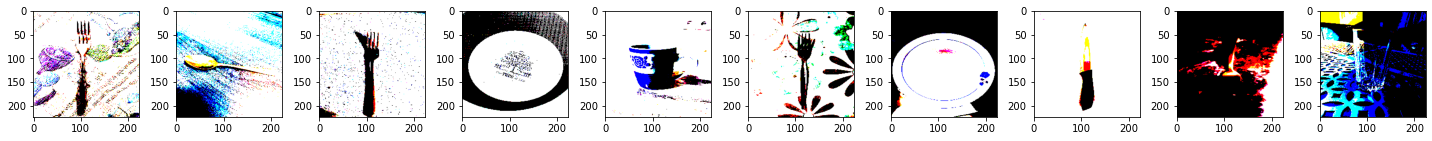

[[0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0.]]


In [111]:
plotImages(imgs)
print(labels)

In [112]:
model = Sequential([
        Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(224,224,3)), #input_shape=(224,224,3) -> 3 -> RGB
        MaxPool2D(pool_size=(2,2), strides=2),
        Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
        MaxPool2D(pool_size=(2,2), strides=2),
        Flatten(), #flatten to 1D 
        Dense(units=6, activation='softmax')])

In [113]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 200704)            0         
                                                                 
 dense (Dense)               (None, 6)                 1

In [114]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [115]:
model.fit(x=train_batches, #labels are contained in the generator itself, therefor you don't see y specified (labels)
          validation_data=valid_batches,
          epochs=10,
          verbose=2)

Epoch 1/10
240/240 - 170s - loss: 17.3626 - accuracy: 0.3583 - val_loss: 2.5850 - val_accuracy: 0.4117 - 170s/epoch - 708ms/step
Epoch 2/10
240/240 - 89s - loss: 0.7106 - accuracy: 0.7937 - val_loss: 2.0905 - val_accuracy: 0.4683 - 89s/epoch - 370ms/step
Epoch 3/10
240/240 - 82s - loss: 0.1338 - accuracy: 0.9650 - val_loss: 2.1137 - val_accuracy: 0.4950 - 82s/epoch - 343ms/step
Epoch 4/10
240/240 - 74s - loss: 0.0425 - accuracy: 0.9954 - val_loss: 2.2107 - val_accuracy: 0.5017 - 74s/epoch - 307ms/step
Epoch 5/10
240/240 - 72s - loss: 0.0330 - accuracy: 0.9975 - val_loss: 2.3475 - val_accuracy: 0.4950 - 72s/epoch - 300ms/step
Epoch 6/10
240/240 - 78s - loss: 0.0267 - accuracy: 0.9987 - val_loss: 2.4676 - val_accuracy: 0.5083 - 78s/epoch - 327ms/step
Epoch 7/10
240/240 - 70s - loss: 0.0277 - accuracy: 0.9992 - val_loss: 2.2908 - val_accuracy: 0.5083 - 70s/epoch - 290ms/step
Epoch 8/10
240/240 - 72s - loss: 0.0272 - accuracy: 0.9987 - val_loss: 2.2933 - val_accuracy: 0.5100 - 72s/epoch - 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

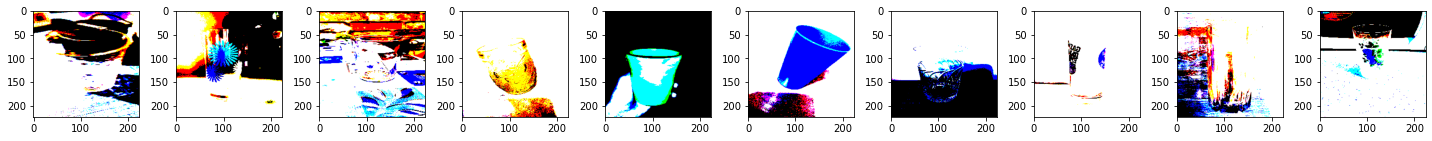

[[1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]]


In [116]:
test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)
print(test_labels)

In [117]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5])

In [118]:
predictions = model.predict(x=test_batches, verbose=0)

In [119]:
np.round(predictions)[:10]

array([[1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)

In [120]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [121]:
test_batches.class_indices

{'glass': 0, 'cup': 1, 'spoon': 2, 'plate': 3, 'knife': 4, 'fork': 5}

In [122]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[28 13  1  4  3  1]
 [12 34  0  3  1  0]
 [ 7  6 14  1 11 11]
 [ 5  9  0 34  2  0]
 [ 2  6  8  2 23  9]
 [ 3  4 12  0  7 24]]


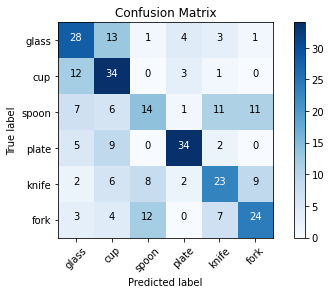

In [123]:
cm_plot_labels = ['glass', 'cup', 'spoon', 'plate', 'knife', 'fork']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

## Finetune the model

In [124]:
vgg16_model = tf.keras.applications.vgg16.VGG16()

In [125]:
model = Sequential()
for layer in vgg16_model.layers[:-1]: #take all layers excepts the last one
    model.add(layer)

In [126]:
for layer in model.layers:
    layer.trainable = False

In [127]:
model.add(Dense(units=6, activation='softmax'))

In [128]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [129]:
model.fit(x=train_batches,
          validation_data=valid_batches,
          epochs=5,
          verbose=2)

Epoch 1/5
240/240 - 331s - loss: 0.8801 - accuracy: 0.6888 - val_loss: 0.5205 - val_accuracy: 0.8283 - 331s/epoch - 1s/step
Epoch 2/5
240/240 - 313s - loss: 0.3739 - accuracy: 0.8679 - val_loss: 0.4203 - val_accuracy: 0.8567 - 313s/epoch - 1s/step
Epoch 3/5
240/240 - 312s - loss: 0.2814 - accuracy: 0.9046 - val_loss: 0.3676 - val_accuracy: 0.8833 - 312s/epoch - 1s/step
Epoch 4/5
240/240 - 332s - loss: 0.2270 - accuracy: 0.9279 - val_loss: 0.3591 - val_accuracy: 0.8833 - 332s/epoch - 1s/step
Epoch 5/5
240/240 - 331s - loss: 0.1920 - accuracy: 0.9421 - val_loss: 0.3397 - val_accuracy: 0.8900 - 331s/epoch - 1s/step


In [130]:
predictions = model.predict(x=test_batches, verbose=0)
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [131]:
test_batches.class_indices

{'glass': 0, 'cup': 1, 'spoon': 2, 'plate': 3, 'knife': 4, 'fork': 5}

Confusion matrix, without normalization
[[45  2  0  2  0  1]
 [ 7 40  1  1  1  0]
 [ 0  0 49  0  0  1]
 [ 0  1  0 49  0  0]
 [ 2  0  0  1 44  3]
 [ 0  2  2  1  6 39]]


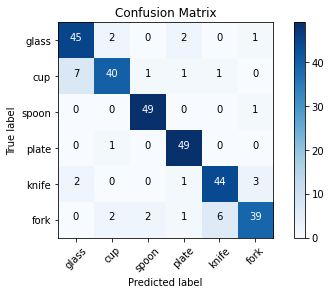

In [132]:
cm_plot_labels = ['glass', 'cup', 'spoon', 'plate', 'knife', 'fork']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [133]:
os.chdir('C:\\Users\\robin\\Documents\\GitHub\\kitchenware_classification\\')
print(os.getcwd())
if os.path.isdir('models') is False:
    os.makedirs('models')
os.chdir('C:\\Users\\robin\\Documents\\GitHub\\kitchenware_classification\\models')
print(os.getcwd())
if os.path.isfile('finetunedvgg16.h5') is False:
    model.save('finetunedvgg16.h5')
os.chdir('../')
print(os.getcwd())

C:\Users\robin\Documents\GitHub\kitchenware_classification
C:\Users\robin\Documents\GitHub\kitchenware_classification\models
C:\Users\robin\Documents\GitHub\kitchenware_classification


### Submission

In [135]:
submission.head()

,Id
0,0678.jpg
1,3962.jpg
2,9271.jpg
3,5133.jpg
4,8842.jpg


In [144]:
#Add the path before the imagenumber.jpg
path = 'C:\\Users\\robin\\Documents\\GitHub\\kitchenware_classification\\data\\submission\\'
submission_images_to_exclude_from_training = [path + string for string in submission_images_to_exclude_from_training]
submission_images_to_exclude_from_training[:5]

['C:\\Users\\robin\\Documents\\GitHub\\kitchenware_classification\\data\\submission\\0678.jpg',
 'C:\\Users\\robin\\Documents\\GitHub\\kitchenware_classification\\data\\submission\\3962.jpg',
 'C:\\Users\\robin\\Documents\\GitHub\\kitchenware_classification\\data\\submission\\9271.jpg',
 'C:\\Users\\robin\\Documents\\GitHub\\kitchenware_classification\\data\\submission\\5133.jpg',
 'C:\\Users\\robin\\Documents\\GitHub\\kitchenware_classification\\data\\submission\\8842.jpg']

In [145]:
import cv2

# Load the images into a list
image_filenames = submission_images_to_exclude_from_training
images = [cv2.imread(filename) for filename in image_filenames]

In [146]:

from keras.applications.vgg16 import preprocess_input

# Resize the images to the VGG16 input size
images = [cv2.resize(image, (224, 224)) for image in images]

# Convert the images to RGB color space
images = [cv2.cvtColor(image, cv2.COLOR_BGR2RGB) for image in images]

# Preprocess the images
images = preprocess_input(np.array(images))

In [147]:
# Predict the labels for the images
predictions = model.predict(images)

# Select the class with the highest predicted probability
predicted_labels = np.argmax(predictions, axis=1)

119/119 [==============================] - 963s 8s/step


In [148]:
predicted_labels

array([2, 4, 5, ..., 2, 5, 2], dtype=int64)

In [149]:
cm_plot_labels

['glass', 'cup', 'spoon', 'plate', 'knife', 'fork']

In [150]:
labels_dictionary = dict(zip([0,1,2,3,4,5], cm_plot_labels))


In [151]:
labels_dictionary

{0: 'glass', 1: 'cup', 2: 'spoon', 3: 'plate', 4: 'knife', 5: 'fork'}

In [152]:
#final_results = map(labels_dictionary.get, predicted_labels)
final_results = [labels_dictionary[key] for key in predicted_labels]


In [153]:
final_results[:5]

['spoon', 'knife', 'fork', 'plate', 'fork']

In [154]:
sample_submission

,Id,label
0,678,spoon
1,3962,glass
2,9271,spoon
3,5133,plate
4,8842,spoon
...,...,...
3803,7626,spoon
3804,2052,cup
3805,8827,glass
3806,2299,knife


In [155]:
submission = submission.assign(C=final_results)
submission.head()

,Id,C
0,0678.jpg,spoon
1,3962.jpg,knife
2,9271.jpg,fork
3,5133.jpg,plate
4,8842.jpg,fork


In [156]:
submission['Id'] = submission['Id'].apply(lambda x: x[:4])
submission.head()

,Id,C
0,0678,spoon
1,3962,knife
2,9271,fork
3,5133,plate
4,8842,fork


In [157]:
submission.columns = ['Id','label']
submission.head()

,Id,label
0,0678,spoon
1,3962,knife
2,9271,fork
3,5133,plate
4,8842,fork


In [159]:
submission[submission['Id']==0000]

,Id,label


In [160]:
submission['Id'] = submission['Id'].str.lstrip('0')

In [161]:
submission.head()

,Id,label
0,678,spoon
1,3962,knife
2,9271,fork
3,5133,plate
4,8842,fork


In [163]:
submission.shape

(3808, 2)

In [ ]:
#ERROR: Expected 'Id' column to be of type 'Int32', but was 'String'

In [171]:
submission['Id'].iloc[47] = 0

In [172]:
submission['Id'] = submission['Id'].astype('int')


In [173]:
submission.to_csv('final_predictions.csv',index=False)

In [176]:
final_predictions = submission.Id.to_list()

In [179]:
submission_original = pd.read_csv('./test.csv')
submission_original = submission_original.Id.to_list()

In [181]:
import difflib

# create a SequenceMatcher object to compare the lists
matcher = difflib.SequenceMatcher(None, submission_original, final_predictions)

# loop through the matching blocks and print the location and size of any differences
for block in matcher.get_matching_blocks():
    if block.size != 0:
        print("Difference found at index: %d, size: %d" % (block.a, block.size))


Difference found at index: 0, size: 3808
